In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, cos, sin, asin, sqrt
from time import time
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

Ici nous avons  rédéfinis les fonctions du module olist à defaut de les avoir importé. 

La formule haversine permet de déterminer la distance du grand cercle
        entre deux points d'une sphère, à partir de leurs longitudes et latitudes.

    Paramètres
    ----------
    lat1, lat2 : float
        Latitudes des 2 points de coordonnées à comparer. 
    lng1, lng2 : float
        Longitudes des 2 points de coordonnées à comparer.
    degrees : boolean
        Si True, converir radians to degrees

In [2]:
def haversine_distance(lat1, lng1, lat2, lng2, degrees=True):
    
    # Radius of the earth in miles
    r = 3956 
    
    if degrees:
        lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])
    
    # Formule Haversine 
    dlng = lng2 - lng1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    d = 2 * r * asin(sqrt(a))  

    return d

Nettoyage et ingénierie des fonctionnalités sur des données Olist complètes
        pour la préparation de la classification non supervisée (K-Means).

    Parameters
    ----------
    dpath : str
        Chemin d'accès au répertoire contenant les données.
    initial : boolean
        Définit si le jeu de données créé est le jeu de données initial.
    period : int
        Période d'incrémentation en mois après l'ensemble de données initial.

In [3]:
def make_dataset(dpath="datas/", initial=False, period=2):
    
    start_time = time()
    print("Création du dataset en cours ...")
    
    #Chemin  path
    root_path = dpath
    
    # On télécharge le jeu de données. 
    customers = pd.read_csv(root_path + "olist_customers_dataset.csv")
    geolocation = pd.read_csv(root_path + "olist_geolocation_dataset.csv")
    orders = pd.read_csv(root_path + "olist_orders_dataset.csv")
    order_items = pd.read_csv(root_path + "olist_order_items_dataset.csv")
    order_payments = pd.read_csv(root_path + "olist_order_payments_dataset.csv")
    order_reviews = pd.read_csv(root_path + "olist_order_reviews_dataset.csv")
    products = pd.read_csv(root_path + "olist_products_dataset.csv")
    categories_en = pd.read_csv(root_path + "product_category_name_translation.csv")
    
    # Emplacement du groupe 
    geolocation = geolocation.groupby(["geolocation_state"]).agg({
            "geolocation_lat": "mean",
            "geolocation_lng": "mean"})
    
    # Merge datasets
    # Orders
    orders.drop(["order_approved_at",
                 "order_delivered_carrier_date", 
                 "order_estimated_delivery_date"],
                axis=1, inplace=True)

    order_items.drop(["seller_id",
                      "shipping_limit_date"],
                     axis=1, inplace=True)
    order_items = pd.merge(order_items, orders,
                           how="left",
                           on="order_id")
    
    datetime_cols = ["order_purchase_timestamp", 
                     "order_delivered_customer_date"]
    for col in datetime_cols:
        order_items[col] = order_items[col].astype('datetime64[ns]')
        
    # mois de commande
    order_items["sale_month"] = order_items['order_purchase_timestamp'].dt.month
    
    # Sélectionnez les commandes sur la période
    start=order_items["order_purchase_timestamp"].min()
    if(initial == True):
        period = 12
    else:
        period = 12+period
    stop=start + pd.DateOffset(months=period)
        
    order_items = order_items[(order_items["order_purchase_timestamp"]>=start)
                              & (order_items["order_purchase_timestamp"]<stop)]
    
    # Liste des commandes sur la période
    period_orders = order_items.order_id.unique()
    
    # Calculer d'autres caractéristiques sur la période
    order_payments = order_payments[order_payments["order_id"].isin(period_orders)]
    order_items = pd.merge(order_items, 
                           order_payments.groupby(by="order_id").agg(
                               {"payment_sequential": 'count',
                                "payment_installments": 'sum'}),
                           how="left",
                           on="order_id")
    order_items = order_items.rename(columns={
        "payment_sequential": "nb_payment_sequential",
        "payment_installments": "sum_payment_installments"})
    
    order_reviews = order_reviews[order_reviews["order_id"].isin(period_orders)]
    order_items = pd.merge(order_items,
                           order_reviews.groupby("order_id").agg({
                               "review_score": "mean"}),
                           how="left",
                           on="order_id")
    
    # Heure de livraison 
    order_items["delivery_delta_days"] = (order_items.order_delivered_customer_date
                                          - order_items.order_purchase_timestamp)\
                                         .dt.round('1d').dt.days
    order_items.drop("order_delivered_customer_date", axis=1, inplace=True)
    
    # Produits
    products = pd.merge(products, categories_en,
                    how="left",
                    on="product_category_name")

    del_features_list = ["product_category_name", "product_weight_g",
                         "product_length_cm", "product_height_cm",
                         "product_width_cm", "product_name_lenght", 
                         "product_description_lenght", "product_photos_qty"]
    products.drop(del_features_list, axis=1, inplace=True)
    products = products.rename(columns={"product_category_name_english":
                                        "product_category_name"})
        
    products['product_category'] = np.where((products['product_category_name'].str.contains("fashio|luggage")==True),
                                    'fashion_clothing_accessories',
                            np.where((products['product_category_name'].str.contains("health|beauty|perfum")==True),
                                     'health_beauty',
                            np.where((products['product_category_name'].str.contains("toy|baby|diaper")==True),
                                     'toys_baby',
                            np.where((products['product_category_name'].str.contains("book|cd|dvd|media")==True),
                                     'books_cds_media',
                            np.where((products['product_category_name'].str.contains("grocer|food|drink")==True), 
                                     'groceries_food_drink',
                            np.where((products['product_category_name'].str.contains("phon|compu|tablet|electro|consol")==True), 
                                     'technology',
                            np.where((products['product_category_name'].str.contains("home|furnitur|garden|bath|house|applianc")==True), 
                                     'home_furniture',
                            np.where((products['product_category_name'].str.contains("flow|gift|stuff")==True),
                                     'flowers_gifts',
                            np.where((products['product_category_name'].str.contains("sport")==True),
                                     'sport',
                                     'other')))))))))
    products.drop("product_category_name", axis=1, inplace=True)

    order_items = pd.merge(order_items, products, 
                           how="left",
                           on="product_id")
    
    # Encoder la colonne des catégories
    order_items = pd.get_dummies(order_items, columns=["product_category"], prefix="", prefix_sep="")
    
    # Clients
    order_items = pd.merge(order_items, customers[["customer_id",
                                                   "customer_unique_id",
                                                   "customer_state"]],
                           on="customer_id",
                           how="left")
    
    # Regrouper les données par clients uniques
    data = order_items.groupby(["customer_unique_id"]).agg(
        nb_orders=pd.NamedAgg(column="order_id", aggfunc="nunique"),
        total_items=pd.NamedAgg(column="order_item_id", aggfunc="count"),
        total_spend=pd.NamedAgg(column="price", aggfunc="sum"),
        total_freight=pd.NamedAgg(column="freight_value", aggfunc="sum"),
        mean_payment_sequential=pd.NamedAgg(column="nb_payment_sequential", aggfunc="mean"),
        mean_payment_installments=pd.NamedAgg(column="sum_payment_installments", aggfunc="mean"),
        mean_review_score=pd.NamedAgg(column="review_score", aggfunc="mean"),
        mean_delivery_days=pd.NamedAgg(column="delivery_delta_days", aggfunc="mean"),
        books_cds_media=pd.NamedAgg(column="books_cds_media", aggfunc="sum"),
        fashion_clothing_accessories=pd.NamedAgg(column="fashion_clothing_accessories", aggfunc="sum"),
        flowers_gifts=pd.NamedAgg(column="flowers_gifts", aggfunc="sum"),
        groceries_food_drink=pd.NamedAgg(column="groceries_food_drink", aggfunc="sum"),
        health_beauty=pd.NamedAgg(column="health_beauty", aggfunc="sum"),
        home_furniture=pd.NamedAgg(column="home_furniture", aggfunc="sum"),
        other=pd.NamedAgg(column="other", aggfunc="sum"),
        sport=pd.NamedAgg(column="sport", aggfunc="sum"),
        technology=pd.NamedAgg(column="technology", aggfunc="sum"),
        toys_baby=pd.NamedAgg(column="toys_baby", aggfunc="sum"),
        customer_state=pd.NamedAgg(column="customer_state", aggfunc="max"),
        first_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="min"),
        last_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="max"),
        favorite_sale_month=pd.NamedAgg(column="sale_month", 
                                        aggfunc=lambda x:x.value_counts().index[0]))
    
    # Feature engineering final
    # Ratio categories items 
    cat_features = data.columns[7:17]
    for c in cat_features:
        data[c] = data[c] / data["total_items"]
    
    # Délai moyen entre 2 commandes
    data["order_mean_delay"] = [(y[1] - y[0]).round('1d').days if y[1] != y[0]
                                else (stop - y[0]).round('1d').days
                                for x,y in data[["first_order","last_order"]].iterrows()]
    data["order_mean_delay"] = data["order_mean_delay"] / data["nb_orders"]
    data.drop(["first_order", "last_order"], axis=1, inplace=True)
    
    # Taux de fret et prix total
    data["freight_ratio"] = (round(data["total_freight"] / (data["total_spend"] + data["total_freight"]),2))
    data["total_spend"] = (data["total_spend"] + data["total_freight"])
    data.drop("total_freight", axis=1, inplace=True)
    
    # Ajouter la distance Haversine de l'état du client
    # Distance Haversine 
    olist_lat = -25.43045
    olist_lon = -49.29207
        
    geolocation['haversine_distance'] = [haversine_distance(olist_lat, olist_lon, x, y)
                                         for x, y in zip(geolocation.geolocation_lat,
                                                         geolocation.geolocation_lng)]
    data = pd.merge(data.reset_index(), geolocation[["haversine_distance"]],
                    how="left",
                    left_on="customer_state",
                    right_on="geolocation_state")
    data.drop(["customer_state"], axis=1, inplace=True)
    data.set_index("customer_unique_id", inplace=True)
    
    # Compléter les valeurs manquantes
    features_to_fill = data.isnull().sum()
    features_to_fill = list(features_to_fill[features_to_fill.values > 0].index)
    
    print(54*"_")
    print("Features complétées avec la valeur la plus fréquente :")
    print(54*"_")
    for f in features_to_fill:
        data[f] = data[f].fillna(data[f].mode()[0])
        print(f,"\t", data[f].mode()[0])
    print(54*"_")
    
    end_time = time()
    print("Durée d'execution du Feature engineering : {:.2f}s".format(end_time - start_time))
    
    return data

In [4]:
# Initial period of 12 months
data_init = make_dataset(dpath="", initial=True, period=2)

Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 8.56s


In [5]:
nouvelles_categories = ['books_cds_media',
                  'fashion_clothing_accessories',
                  'flowers_gifts',
                  'groceries_food_drink',
                  'health_beauty',
                  'home_furniture',
                  'other',
                  'sport',
                  'technology',
                  'toys_baby']

In [6]:
data_init.drop(nouvelles_categories, axis=1, inplace=True)

In [7]:
data_init.head()

,nb_orders,total_items,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,order_mean_delay,freight_ratio,haversine_distance
customer_unique_id,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,1,1,86.22,1.0,8.0,3.0,26.0,3,178.0,0.20,125.363853
0005e1862207bf6ccc02e4228effd9a0,1,1,150.12,1.0,3.0,4.0,4.0,3,184.0,0.10,428.916514
0006fdc98a402fceb4eb0ee528f6a8d4,1,1,29.00,1.0,2.0,3.0,16.0,7,48.0,0.52,669.215559
000a5ad9c4601d2bbdd9ed765d5213b3,1,1,91.28,1.0,3.0,4.0,11.0,8,24.0,0.16,337.899660
000de6019bb59f34c099a907c151d855,1,2,257.44,1.0,4.0,2.0,2.0,8,18.0,0.11,209.713834


Nous allons ensuite déterminer la période totale à couvrir :

In [8]:
olist_path = ""
orders = pd.read_csv(olist_path+"olist_orders_dataset.csv")
orders = orders.loc[orders.order_status == "delivered", 
                    "order_purchase_timestamp"]
orders = pd.to_datetime(orders)
time_delta = int((orders.max() - orders.min())/np.timedelta64(1,'M'))
print("La période complète des commandes porte sur {} mois.".format(time_delta))

La période complète des commandes porte sur 23 mois.


In [9]:
from pickle import *
f = open("k","rb")
K = load(f)
f.close()

Pour déterminer le moment où les clients changent de cluster, nous allons itérer le K-Means sur toute la période avec des deltas de 2 mois et calculer le score ARI, en prenant garde à bien comparer les mêmes clients (ceux des 12 mois initiaux).

Ici le déroulé est créé directement dans le notebook pour explication, en production, toutes ses opérations seront regroupées dans une classe Python pour automatiser le processus.

In [12]:
# Kmeans sur la période initiale
kmeans_init = Pipeline([("preprocessor", MinMaxScaler()),
                        ("kmeans", KMeans(K, random_state=42))])
kmeans_init.fit(data_init)
init_labels = kmeans_init.named_steps['kmeans'].labels_

In [13]:
ari_score = []
for p in np.arange(2,(time_delta-12),2):
    # Créer un jeu de données pour la période
    data_period = make_dataset(dpath="", 
                                   initial=False, 
                                   period=p)
    data_period.drop(nouvelles_categories, axis=1, inplace=True)
    
    # Filtrer sur client initial
    data_period = data_period[data_period.index.isin(data_init.index)]
    
    # K-Means
    kmeans_p = Pipeline([("preprocessor", MinMaxScaler()),
                         ("kmeans", KMeans(K, random_state=42))])
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_
    
    # Calcul de l'ARI score
    ari_p = adjusted_rand_score(init_labels, kmeans_p[1].labels_)
    ari_score.append([p,ari_p])

Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 9.90s
Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 8.0
______________________________________________________
Durée d'execution du Feature engineering : 13.12s
Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________

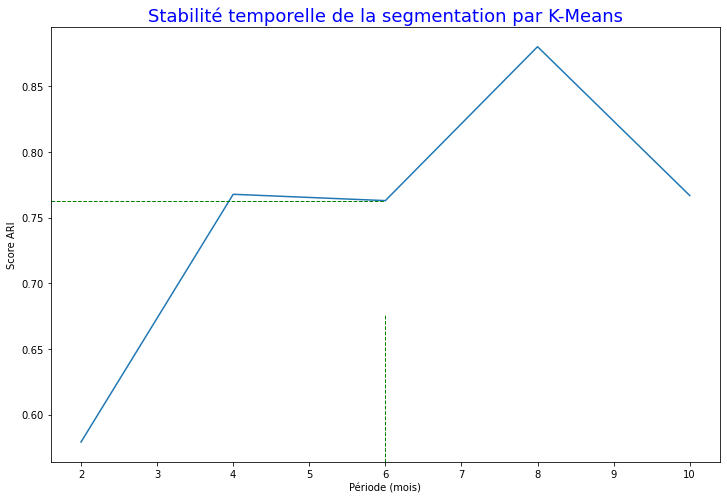

In [18]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.axhline(y=ari_score.iloc[2][1], linestyle="--", 
            color="green",
            xmax=0.5,
            linewidth=1)
plt.axvline(x=ari_score.iloc[2][0], linestyle="--", 
            color="green",
            ymax=1.1-(ari_score.iloc[2][1]),
            linewidth=1)
plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()